In [1]:
import os
import json
from typing import Dict, List, Optional, Union, cast
import requests
import pandas as pd
from env import github_token, github_username

import prepare
import acquire
import explore
import model

import unicodedata
import re
import json

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filter="ignore"

from bs4 import BeautifulSoup
from mergedeep import merge


In [2]:
#Acquire the URLS for the Repositories to explore

headers = acquire.headers
endpoint = "https://api.github.com/search/repositories"
query = "customer in:name"
sort = "stars"
per_page = 100
order = "desc"
page = 1

##Make the request
response = requests.get(f"{endpoint}?q={query}&sort={sort}&per_page={per_page}&order={order}&page={page}", headers=headers)
payload = response.json()
payload['items']

[{'id': 71693277,
  'node_id': 'MDEwOlJlcG9zaXRvcnk3MTY5MzI3Nw==',
  'name': 'CustomerManagement',
  'full_name': 'codingXiaxw/CustomerManagement',
  'private': False,
  'owner': {'login': 'codingXiaxw',
   'id': 17295340,
   'node_id': 'MDQ6VXNlcjE3Mjk1MzQw',
   'avatar_url': 'https://avatars.githubusercontent.com/u/17295340?v=4',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/codingXiaxw',
   'html_url': 'https://github.com/codingXiaxw',
   'followers_url': 'https://api.github.com/users/codingXiaxw/followers',
   'following_url': 'https://api.github.com/users/codingXiaxw/following{/other_user}',
   'gists_url': 'https://api.github.com/users/codingXiaxw/gists{/gist_id}',
   'starred_url': 'https://api.github.com/users/codingXiaxw/starred{/owner}{/repo}',
   'subscriptions_url': 'https://api.github.com/users/codingXiaxw/subscriptions',
   'organizations_url': 'https://api.github.com/users/codingXiaxw/orgs',
   'repos_url': 'https://api.github.com/users/codingXiaxw/repos'

In [3]:
page = 2

##Make the request
response = requests.get(f"{endpoint}?q={query}&sort={sort}&per_page={per_page}&order={order}&page={page}", headers=headers)
payload2 = response.json()
merge(payload, payload2)
payload['items'] 

[{'id': 129873405,
  'node_id': 'MDEwOlJlcG9zaXRvcnkxMjk4NzM0MDU=',
  'name': 'CustomerReorderPlugin',
  'full_name': 'Sylius/CustomerReorderPlugin',
  'private': False,
  'owner': {'login': 'Sylius',
   'id': 719423,
   'node_id': 'MDEyOk9yZ2FuaXphdGlvbjcxOTQyMw==',
   'avatar_url': 'https://avatars.githubusercontent.com/u/719423?v=4',
   'gravatar_id': '',
   'url': 'https://api.github.com/users/Sylius',
   'html_url': 'https://github.com/Sylius',
   'followers_url': 'https://api.github.com/users/Sylius/followers',
   'following_url': 'https://api.github.com/users/Sylius/following{/other_user}',
   'gists_url': 'https://api.github.com/users/Sylius/gists{/gist_id}',
   'starred_url': 'https://api.github.com/users/Sylius/starred{/owner}{/repo}',
   'subscriptions_url': 'https://api.github.com/users/Sylius/subscriptions',
   'organizations_url': 'https://api.github.com/users/Sylius/orgs',
   'repos_url': 'https://api.github.com/users/Sylius/repos',
   'events_url': 'https://api.github.c

In [4]:
#Convert the reponse to a data frame
urls_df = pd.DataFrame(payload['items'])

In [5]:
#Check the shape of the dataframe
urls_df.shape

(100, 75)

In [6]:
urls_df

,id,node_id,name,full_name,private,owner,html_url,description,fork,url,...,archived,disabled,open_issues_count,license,forks,open_issues,watchers,default_branch,permissions,score
0,129873405,MDEwOlJlcG9zaXRvcnkxMjk4NzM0MDU=,CustomerReorderPlugin,Sylius/CustomerReorderPlugin,False,"{'login': 'Sylius', 'id': 719423, 'node_id': '...",https://github.com/Sylius/CustomerReorderPlugin,Plugin that allows customers to reorder previo...,False,https://api.github.com/repos/Sylius/CustomerRe...,...,False,False,4,None,14,4,20,master,"{'admin': False, 'push': False, 'pull': True}",1.0
1,142269252,MDEwOlJlcG9zaXRvcnkxNDIyNjkyNTI=,Customer-Analytics,Prakhar-FF13/Customer-Analytics,False,"{'login': 'Prakhar-FF13', 'id': 23739449, 'nod...",https://github.com/Prakhar-FF13/Customer-Analy...,Machine Learning Case study on customer segmen...,False,https://api.github.com/repos/Prakhar-FF13/Cust...,...,False,False,0,None,21,0,20,master,"{'admin': False, 'push': False, 'pull': True}",1.0
2,70282465,MDEwOlJlcG9zaXRvcnk3MDI4MjQ2NQ==,customers-accounts-and-money-transfers,crctraining/customers-accounts-and-money-trans...,False,"{'login': 'crctraining', 'id': 13845390, 'node...",https://github.com/crctraining/customers-accou...,One of the example applications used in Chris ...,False,https://api.github.com/repos/crctraining/custo...,...,False,False,0,None,22,0,20,master,"{'admin': False, 'push': False, 'pull': True}",1.0
3,95365412,MDEwOlJlcG9zaXRvcnk5NTM2NTQxMg==,ovh-ipxe-customer-script,gmasse/ovh-ipxe-customer-script,False,"{'login': 'gmasse', 'id': 8754722, 'node_id': ...",https://github.com/gmasse/ovh-ipxe-customer-sc...,Boot OVH server with your own iPXE script,False,https://api.github.com/repos/gmasse/ovh-ipxe-c...,...,False,False,2,"{'key': 'bsd-3-clause', 'name': 'BSD 3-Clause ...",5,2,20,master,"{'admin': False, 'push': False, 'pull': True}",1.0
4,75255555,MDEwOlJlcG9zaXRvcnk3NTI1NTU1NQ==,customer-support,requestly/customer-support,False,"{'login': 'requestly', 'id': 12287519, 'node_i...",https://github.com/requestly/customer-support,"A repository for logging feature enhancements,...",False,https://api.github.com/repos/requestly/custome...,...,False,False,6,None,2,6,20,master,"{'admin': False, 'push': False, 'pull': True}",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,117395661,MDEwOlJlcG9zaXRvcnkxMTczOTU2NjE=,example-customers-app,correooke/example-customers-app,False,"{'login': 'correooke', 'id': 8355916, 'node_id...",https://github.com/correooke/example-customers...,None,False,https://api.github.com/repos/correooke/example...,...,False,False,1,None,18,1,10,master,"{'admin': False, 'push': False, 'pull': True}",1.0
96,47967191,MDEwOlJlcG9zaXRvcnk0Nzk2NzE5MQ==,customer-scripts,microsoft/customer-scripts,False,"{'login': 'microsoft', 'id': 6154722, 'node_id...",https://github.com/microsoft/customer-scripts,Repository of scripts provided frequently to o...,False,https://api.github.com/repos/microsoft/custome...,...,True,False,1,"{'key': 'mit', 'name': 'MIT License', 'spdx_id...",13,1,10,master,"{'admin': False, 'push': False, 'pull': True}",1.0
97,203420605,MDEwOlJlcG9zaXRvcnkyMDM0MjA2MDU=,nr1-customer-journey,newrelic/nr1-customer-journey,False,"{'login': 'newrelic', 'id': 31739, 'node_id': ...",https://github.com/newrelic/nr1-customer-journey,Align multiple cohorts of data and metrics to ...,False,https://api.github.com/repos/newrelic/nr1-cust...,...,False,False,6,"{'key': 'apache-2.0', 'name': 'Apache License ...",16,6,10,develop,"{'admin': False, 'push': False, 'pull': True}",1.0
98,74846002,MDEwOlJlcG9zaXRvcnk3NDg0NjAwMg==,mlnd-customer-segments,darkdreamingdan/mlnd-customer-segments,False,"{'login': 'darkdreamingdan', 'id': 124611, 'no...",https://github.com/darkdreamingdan/mlnd-custom...,udacity machine learning nanodegree Project 3:...,False,https://api.github.com/repos/darkdreamingdan/m...,...,False,False,0,None,14,0,10,master,"{'admin': False, 'push': False, 'pull': True}",1.0


In [7]:
#Get a list of the full_name for the urls
urls_df.full_name.to_list()

['Sylius/CustomerReorderPlugin',
 'Prakhar-FF13/Customer-Analytics',
 'crctraining/customers-accounts-and-money-transfers',
 'gmasse/ovh-ipxe-customer-script',
 'requestly/customer-support',
 'xamarin/app-customers',
 'navdeep-G/customer-churn',
 'php-cuong/magento2-customer-avatar',
 '2427595858/customer-maven',
 'kiwicommerce/magento2-login-as-customer',
 'gongdelu/E-commerce-Customer-service-robot',
 'optiflow/rfm-customer-segmentation',
 'klein0r/magento-customer-helper',
 'watson-developer-cloud/customer-engagement-bot',
 'pusher-community/customer-support-chat-example',
 'nenes25/prestashop_customerautogroups',
 'fateh491989/customersuppert_admin',
 'SonarSoftwareInc/customer_portal',
 'printu/customerio',
 'pyxploiter/customer-service-chatbot',
 'pabitralenka/Customer-Feedback-Analysis',
 'jeremyjordan/customer-segmentation',
 'mageplaza/magento-2-login-as-customer',
 'mapr-demos/customer360',
 'makeyourcloud/myc-vtiger-customer-portal',
 'sisl/CustomerSim',
 'seifip/starbucks-c

In [8]:
#Use the scrape github function from the acquire module to acquire the dataframe containing the names of the
#repositories and the contents of the readme files
#df = acquire.scrape_github_data()

#convert the data into a dataframe
#df = pd.DataFrame(df)
#df.head()

In [9]:
df = pd.read_json('data2.json')

In [10]:
df

,repo,language,readme_contents
0,codingXiaxw/CustomerManagement,Java,## JavaWeb项目之客户管理系统 \n\n## 项目介绍\n详细讲解请点击这里前往我的...
1,DanWahlin/CustomerManager,JavaScript,Customer Manager with AngularJS (with custom r...
2,Tophold/FinancialCustomerView,Java,## FinancialCustomerView\n* 本项目会对金融交易软件中存在的各种V...
3,DanWahlin/CustomerManagerStandard,JavaScript,Customer Manager with AngularJS\r\n===========...
4,spring-cloud-samples/customers-stores,Java,# REST based micro-services sample\n\n- Three ...
...,...,...,...
93,facebookincubator/wordpress-messenger-customer...,PHP,# What is WordPress Messenger Customer Chat Pl...
94,kpei/Customer-Analytics,Jupyter Notebook,# Customer Analytics iPython Notebook\nSee htt...
95,Sylius/CustomerOrderCancellationPlugin,PHP,"<p align=""center"">\n <a href=""https://syliu..."
96,Azure/fta-customerfacingapps,C#,# FastTrack for Azure\n\nSee our [FastTrack fo...


In [11]:
df.shape

(98, 3)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             98 non-null     object
 1   language         93 non-null     object
 2   readme_contents  98 non-null     object
dtypes: object(3)
memory usage: 2.4+ KB


In [13]:
df.language.value_counts()


PHP                 18
Java                14
JavaScript          14
Jupyter Notebook    13
Python               9
C#                   7
TypeScript           3
R                    3
Go                   2
HTML                 2
Ruby                 2
Vue                  1
PowerShell           1
Scala                1
Shell                1
Dart                 1
CSS                  1
Name: language, dtype: int64

In [14]:
df = df.dropna()

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 0 to 97
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             93 non-null     object
 1   language         93 non-null     object
 2   readme_contents  93 non-null     object
dtypes: object(3)
memory usage: 2.9+ KB


In [16]:
df = prepare.drop_unneeded_data(df)

In [17]:
df

,repo,language,readme_contents
0,DanWahlin/CustomerManager,JavaScript,Customer Manager with AngularJS (with custom r...
1,DanWahlin/CustomerManagerStandard,JavaScript,Customer Manager with AngularJS\r\n===========...
2,spring-cloud-samples/customers-stores,Java,# REST based micro-services sample\n\n- Three ...
3,eventuate-tram/eventuate-tram-examples-custome...,Java,# Eventuate Tram Customers and Orders\n\nThis ...
4,Featuretools/predict-customer-churn,Jupyter Notebook,# A Machine Learning Framework with an Applica...
5,eventuate-examples/eventuate-examples-java-cus...,Java,This is the Java version of the customers and ...
6,eventuate-tram/eventuate-tram-sagas-examples-c...,Java,\n= Eventuate Tram Sagas Customers and Orders\...
7,Yoctol/react-messenger-customer-chat,JavaScript,# React Messenger Customer Chat\n\n> React com...
8,KazukiOnodera/Santander-Customer-Transaction-P...,Jupyter Notebook,# Santander-Customer-Transaction-Prediction\n\...
9,Vinai/customer-activation,PHP,"# This Magento 1 extension is orphaned, unsupp..."


In [18]:
df = prepare.prepare_nlp_data(df, content = 'readme_contents')

In [19]:
df

,repo,language,readme_contents,clean,stemmed,lemmatized
0,DanWahlin/CustomerManager,JavaScript,Customer Manager with AngularJS (with custom r...,customer manager angularjs custom routing dyna...,custom manag angularj custom rout dynam contro...,customer manager angularjs custom routing dyna...
1,DanWahlin/CustomerManagerStandard,JavaScript,Customer Manager with AngularJS\r\n===========...,customer manager angularjs youre new angularjs...,custom manag angularj your new angularj check ...,customer manager angularjs youre new angularjs...
2,spring-cloud-samples/customers-stores,Java,# REST based micro-services sample\n\n- Three ...,rest based microservices sample three spring b...,rest base microservic sampl three spring boot ...,rest based microservices sample three spring b...
3,eventuate-tram/eventuate-tram-examples-custome...,Java,# Eventuate Tram Customers and Orders\n\nThis ...,eventuate tram customers orders application de...,eventu tram custom order applic demonstr two k...,eventuate tram customer order application demo...
4,Featuretools/predict-customer-churn,Jupyter Notebook,# A Machine Learning Framework with an Applica...,machine learning framework application predict...,machin learn framework applic predict custom c...,machine learning framework application predict...
5,eventuate-examples/eventuate-examples-java-cus...,Java,This is the Java version of the customers and ...,java version customers orders example ive used...,java version custom order exampl ive use numer...,java version customer order example ive used n...
6,eventuate-tram/eventuate-tram-sagas-examples-c...,Java,\n= Eventuate Tram Sagas Customers and Orders\...,eventuate tram sagas customers orders applicat...,eventu tram saga custom order applic demonstr ...,eventuate tram saga customer order application...
7,Yoctol/react-messenger-customer-chat,JavaScript,# React Messenger Customer Chat\n\n> React com...,react messenger customer chat react component ...,react messeng custom chat react compon messeng...,react messenger customer chat react component ...
8,KazukiOnodera/Santander-Customer-Transaction-P...,Jupyter Notebook,# Santander-Customer-Transaction-Prediction\n\...,santandercustomertransactionprediction leaderb...,santandercustomertransactionpredict leaderboar...,santandercustomertransactionprediction leaderb...
9,Vinai/customer-activation,PHP,"# This Magento 1 extension is orphaned, unsupp...",magento 1 extension orphaned unsupported longe...,magento 1 extens orphan unsupport longer maint...,magento 1 extension orphaned unsupported longe...


In [20]:
all_word_counts = explore.get_word_counts_series(df, 'clean')
java_word_counts = explore.get_word_counts_series(df[df.language == 'Java'], 'clean')
javascript_word_counts = explore.get_word_counts_series(df[df.language == 'JavaScript'], 'clean')
php_word_counts = explore.get_word_counts_series(df[df.language == 'PHP'], 'clean')
jupyter_word_counts = explore.get_word_counts_series(df[df.language == 'Jupyter Notebook'], 'clean')

In [21]:
all_word_counts

customer                                                 258
order                                                    147
data                                                     144
service                                                  140
using                                                    137
                                                        ... 
extensionhttpsmagefancommagento2twittercardsextension      1
1600                                                       1
contribuidores                                             1
4000                                                       1
hrefhttpsbundlephobiacomresultpvuefbcustomerchat           1
Length: 4455, dtype: int64

In [22]:
java_word_counts

service         121
order           114
customer         58
using            54
application      38
               ... 
push              1
availability      1
created           1
log               1
andor             1
Length: 936, dtype: int64

In [23]:
javascript_word_counts

install                              45
customer                             42
using                                39
network                              37
application                          37
                                     ..
width1000                             1
chatbots                              1
connecting                            1
commercial                            1
dynamodbhttpsawsamazoncomdynamodb     1
Length: 1121, dtype: int64

In [24]:
php_word_counts

customer                   136
magento                    121
2                           56
portal                      50
extension                   44
                          ... 
moved                        1
testes                       1
platforms                    1
yourchargebeesiteapikey      1
repositories                 1
Length: 1548, dtype: int64

In [25]:
jupyter_word_counts

data                               91
python                             63
model                              57
1                                  39
loss                               37
                                   ..
namedecoder                         1
thregisteredviath                   1
1000                                1
intelligence                        1
githubhttpsgithubcomrileypredum     1
Length: 2077, dtype: int64

In [26]:
df.language.value_counts()


PHP                 17
JavaScript          13
Jupyter Notebook    12
Java                10
Name: language, dtype: int64

In [27]:
df

,repo,language,readme_contents,clean,stemmed,lemmatized
0,DanWahlin/CustomerManager,JavaScript,Customer Manager with AngularJS (with custom r...,customer manager angularjs custom routing dyna...,custom manag angularj custom rout dynam contro...,customer manager angularjs custom routing dyna...
1,DanWahlin/CustomerManagerStandard,JavaScript,Customer Manager with AngularJS\r\n===========...,customer manager angularjs youre new angularjs...,custom manag angularj your new angularj check ...,customer manager angularjs youre new angularjs...
2,spring-cloud-samples/customers-stores,Java,# REST based micro-services sample\n\n- Three ...,rest based microservices sample three spring b...,rest base microservic sampl three spring boot ...,rest based microservices sample three spring b...
3,eventuate-tram/eventuate-tram-examples-custome...,Java,# Eventuate Tram Customers and Orders\n\nThis ...,eventuate tram customers orders application de...,eventu tram custom order applic demonstr two k...,eventuate tram customer order application demo...
4,Featuretools/predict-customer-churn,Jupyter Notebook,# A Machine Learning Framework with an Applica...,machine learning framework application predict...,machin learn framework applic predict custom c...,machine learning framework application predict...
5,eventuate-examples/eventuate-examples-java-cus...,Java,This is the Java version of the customers and ...,java version customers orders example ive used...,java version custom order exampl ive use numer...,java version customer order example ive used n...
6,eventuate-tram/eventuate-tram-sagas-examples-c...,Java,\n= Eventuate Tram Sagas Customers and Orders\...,eventuate tram sagas customers orders applicat...,eventu tram saga custom order applic demonstr ...,eventuate tram saga customer order application...
7,Yoctol/react-messenger-customer-chat,JavaScript,# React Messenger Customer Chat\n\n> React com...,react messenger customer chat react component ...,react messeng custom chat react compon messeng...,react messenger customer chat react component ...
8,KazukiOnodera/Santander-Customer-Transaction-P...,Jupyter Notebook,# Santander-Customer-Transaction-Prediction\n\...,santandercustomertransactionprediction leaderb...,santandercustomertransactionpredict leaderboar...,santandercustomertransactionprediction leaderb...
9,Vinai/customer-activation,PHP,"# This Magento 1 extension is orphaned, unsupp...",magento 1 extension orphaned unsupported longe...,magento 1 extens orphan unsupport longer maint...,magento 1 extension orphaned unsupported longe...


In [28]:
all_word_counts[all_word_counts.index == 'customer']

customer    258
dtype: int64

In [29]:
word_counts_list = [java_word_counts, javascript_word_counts, php_word_counts, jupyter_word_counts, all_word_counts]
column_names = list(df.language.unique())
column_names.append('all')

languages = list(df.language.unique())

In [30]:
word_counts = pd.concat(word_counts_list, axis=1).fillna(0).astype(int)
word_counts.columns = column_names
word_counts.head()

,JavaScript,Java,Jupyter Notebook,PHP,all
service,121,13,1,5,140
order,114,2,29,2,147
customer,58,42,136,22,258
using,54,39,21,23,137
application,38,37,0,10,85


In [31]:
blues = [ '#f1faee', '#a8dadc', '#457b9d', '#1d3557', '#e63946']

<Figure size 1152x648 with 0 Axes>

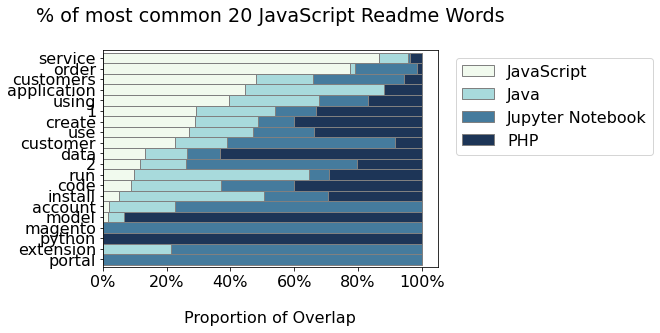

<Figure size 1152x648 with 0 Axes>

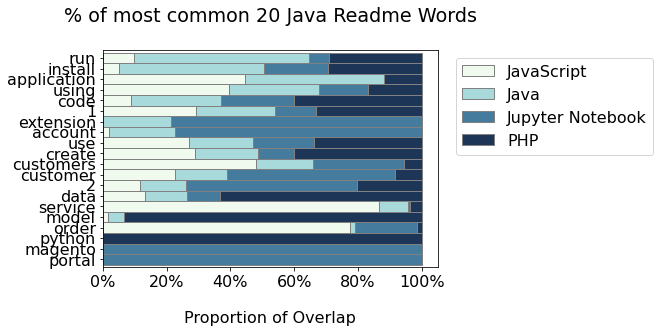

<Figure size 1152x648 with 0 Axes>

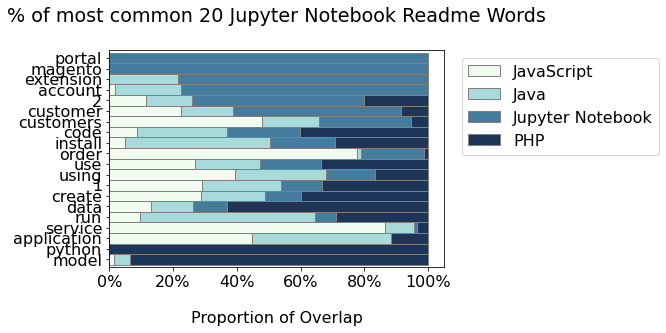

<Figure size 1152x648 with 0 Axes>

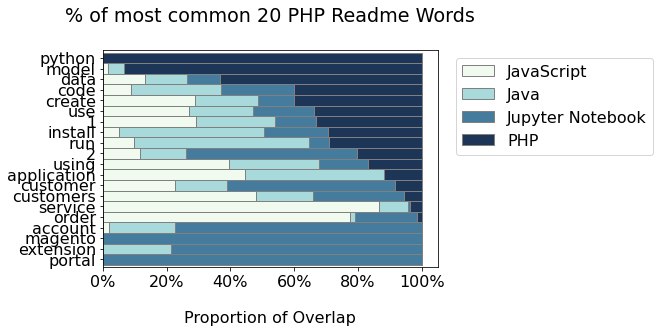

In [32]:
for language in languages:
    explore.plot_overlap_stacked_bar(word_counts, language, colors=blues)

In [37]:
tfidf = TfidfVectorizer()
X_data = tfidf.fit_transform(df.clean)
y_data = df.language

# use function from above (need to put in a module)
# split to X/y datasets 

X_train, y_train, X_validate, y_validate, X_test, y_test = model.nlp_X_train_split(X_data, y_data)

In [38]:
score_df = pd.DataFrame(columns = ['model_name', 'train_score', 'validate_score'])

In [41]:
df.language.value_counts()

PHP                 17
JavaScript          13
Jupyter Notebook    12
Java                10
Name: language, dtype: int64

In [42]:
#PHP is the baseline prediction
print(f'Baseline Accuracy: {round(max(df.language.value_counts()) / df.shape[0] *100)}%')

Baseline Accuracy: 33%


**Logistic Regression**

In [45]:
#Using the vectorized data, make a logistic regression model
lm = LogisticRegression()

#Fit the lm object to the vectorized data
lm.fit(X_train, y_train)

#Create corresponding dataframes for the actual values of the categories that correspond to each article
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

#Form predictions uisng the lm model
train['predicted'] = lm.predict(X_train)
validate["predicted"] = lm.predict(X_validate)
test['predicted'] = lm.predict(X_test)

#Review how the lm model performed on the in-sample data
print('In-sample data model performance:')
print(classification_report(train.actual, train.predicted, zero_division=0))
print('----------------')
#Review how the lm model performed on the out-of-sample data
print('Out-of-sample data model performance:')
print(classification_report(validate.actual, validate.predicted, zero_division=0))


In-sample data model performance:
                  precision    recall  f1-score   support

            Java       1.00      1.00      1.00         5
      JavaScript       1.00      1.00      1.00         7
Jupyter Notebook       1.00      1.00      1.00         7
             PHP       1.00      1.00      1.00         9

        accuracy                           1.00        28
       macro avg       1.00      1.00      1.00        28
    weighted avg       1.00      1.00      1.00        28

----------------
Out-of-sample data model performance:
                  precision    recall  f1-score   support

            Java       1.00      0.33      0.50         3
      JavaScript       0.00      0.00      0.00         3
Jupyter Notebook       1.00      0.33      0.50         3
             PHP       0.36      1.00      0.53         4

        accuracy                           0.46        13
       macro avg       0.59      0.42      0.38        13
    weighted avg       0.57      0.4

**KNN Model**

In [46]:
#Create the KNN object with a k = 10
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')

#Fit the object to the vectorized training data
knn.fit(X_train, y_train)

#Create corresponding dataframes for the actual values of the categories that correspond to each article
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

#Form predictions uisng the knn model
train['predicted'] = knn.predict(X_train)
validate["predicted"] = knn.predict(X_validate)

#Review how the knn model performed on the in-sample data
print('In-sample data model performance:')
print(classification_report(train.actual, train.predicted,  zero_division=0))
print('----------------')
#Review how the knn model performed on the out-of-sample data
print('Out-of-sample data model performance:')
print(classification_report(validate.actual, validate.predicted, zero_division=0))

In-sample data model performance:
                  precision    recall  f1-score   support

            Java       1.00      1.00      1.00         5
      JavaScript       1.00      1.00      1.00         7
Jupyter Notebook       1.00      1.00      1.00         7
             PHP       1.00      1.00      1.00         9

        accuracy                           1.00        28
       macro avg       1.00      1.00      1.00        28
    weighted avg       1.00      1.00      1.00        28

----------------
Out-of-sample data model performance:
                  precision    recall  f1-score   support

            Java       1.00      0.33      0.50         3
      JavaScript       0.75      1.00      0.86         3
Jupyter Notebook       1.00      1.00      1.00         3
             PHP       0.80      1.00      0.89         4

        accuracy                           0.85        13
       macro avg       0.89      0.83      0.81        13
    weighted avg       0.88      0.8

**Random Forest Model**

In [48]:
#Create the RF object
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=2,
                            n_estimators=100,
                            max_depth=15, 
                            random_state=123)

#Fit the RF object to the training data
rf.fit(X_train, y_train)

#Predict on y
y_pred = rf.predict(X_train)

#Evaluate
print('In-sample data model performance:')
print(classification_report(y_train, y_pred))

#Predict using out of sample data
y_pred = rf.predict(X_validate)
print('----------------')
print('Out-of-sample data model performance:')
print(classification_report(y_validate, y_pred, zero_division=0))

In-sample data model performance:
                  precision    recall  f1-score   support

            Java       1.00      0.80      0.89         5
      JavaScript       1.00      1.00      1.00         7
Jupyter Notebook       1.00      1.00      1.00         7
             PHP       0.90      1.00      0.95         9

        accuracy                           0.96        28
       macro avg       0.97      0.95      0.96        28
    weighted avg       0.97      0.96      0.96        28

----------------
Out-of-sample data model performance:
                  precision    recall  f1-score   support

            Java       1.00      0.33      0.50         3
      JavaScript       1.00      1.00      1.00         3
Jupyter Notebook       1.00      0.67      0.80         3
             PHP       0.57      1.00      0.73         4

        accuracy                           0.77        13
       macro avg       0.89      0.75      0.76        13
    weighted avg       0.87      0.7

**Decision Tree Modeling**

In [49]:
#Make the CLF object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=9, random_state=123)

#Fit the model on the training set 
clf = clf.fit(X_train, y_train)

#Make predictions
y_pred = clf.predict(X_train)

#Evaluate model performance on training data
print('In-sample data model performance:')
print(classification_report(y_train, y_pred))

# Predict on validate
y_pred = clf.predict(X_validate)

# Evaluate model performance on out-of-sample data
print('Out-of-sample data model performance:')
print(classification_report(y_validate, y_pred, zero_division=0))


In-sample data model performance:
                  precision    recall  f1-score   support

            Java       1.00      1.00      1.00         5
      JavaScript       1.00      1.00      1.00         7
Jupyter Notebook       1.00      1.00      1.00         7
             PHP       1.00      1.00      1.00         9

        accuracy                           1.00        28
       macro avg       1.00      1.00      1.00        28
    weighted avg       1.00      1.00      1.00        28

Out-of-sample data model performance:
                  precision    recall  f1-score   support

            Java       0.67      0.67      0.67         3
      JavaScript       1.00      1.00      1.00         3
Jupyter Notebook       0.67      0.67      0.67         3
             PHP       0.75      0.75      0.75         4

        accuracy                           0.77        13
       macro avg       0.77      0.77      0.77        13
    weighted avg       0.77      0.77      0.77      